In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tqdm import tqdm
import os
import cv2
from sklearn.utils import shuffle
import common_functions as cf
import importlib
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
importlib.reload(cf)

<module 'common_functions' from 'd:\\Work\\Programming\\Jupyter\\Traffic Object Detection\\common_functions.py'>

# Image Processing

In [3]:
# Input Folders
main_folder = 'dataset/traffic_object_detection'
train_folder = f'{main_folder}/train'
test_folder = f'{main_folder}/test'
valid_folder = f'{main_folder}/valid'

classes = ['bicycle', 'bus', 'car', 'motorbike', 'person']
colors = [[0, 255, 0], [255, 0, 0], [0, 0, 255], [200, 200, 0], [200, 200, 200]]

## Data Display

aguanambi-1245_png_jpg.rf.aed607cde6491882fbc7a9d62164d044.txt aguanambi-1245_png_jpg.rf.aed607cde6491882fbc7a9d62164d044.jpg


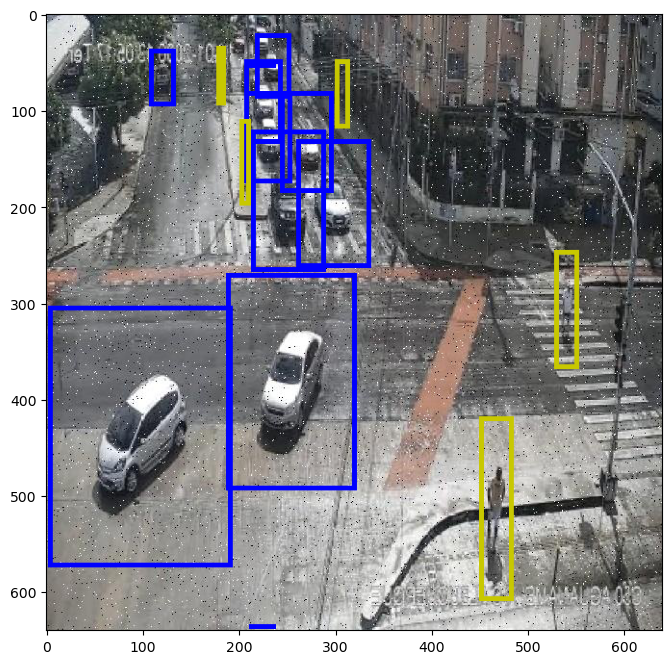

In [4]:
# Loading data
image_index = 50
images = os.listdir(f'{train_folder}/images')
labels = os.listdir(f'{train_folder}/labels')
image = plt.imread(f'{train_folder}/images/{images[image_index]}')
label = ''
object_coordinates = []
with open(f'{train_folder}/labels/{labels[image_index]}', 'r') as file:
    label = file.readlines()
new_image = image.copy()
for lab in label:
    coordinates = [float(num) for num in lab.split(' ')]
    new_image, coords = cf.draw_boundary(new_image, colors[int(coordinates[0])], coordinates)
    object_coordinates.append(coords)

print(labels[image_index], images[image_index])

plt.figure(figsize=(8, 8))
plt.imshow(new_image)

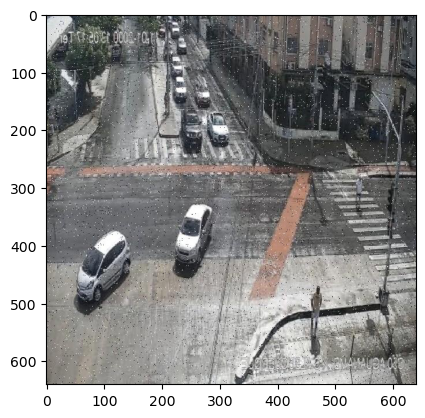

In [5]:
sss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
sss.setBaseImage(image)
sss.switchToSelectiveSearchFast()
ssresults = sss.process()
plt.imshow(image)

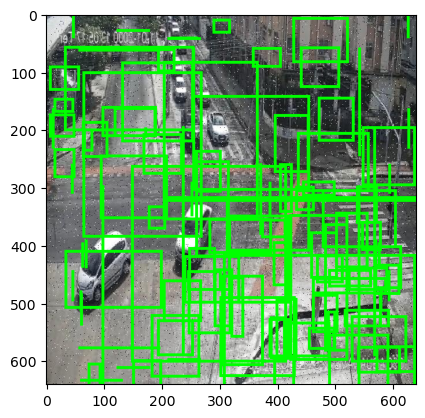

In [6]:
processed_image = image.copy()
for i in range(100):
    processed_image = cf.draw_boundary(processed_image, colors[0], ssresults[i], True, upScale=False)
plt.imshow(processed_image)

# Defining Data Generator

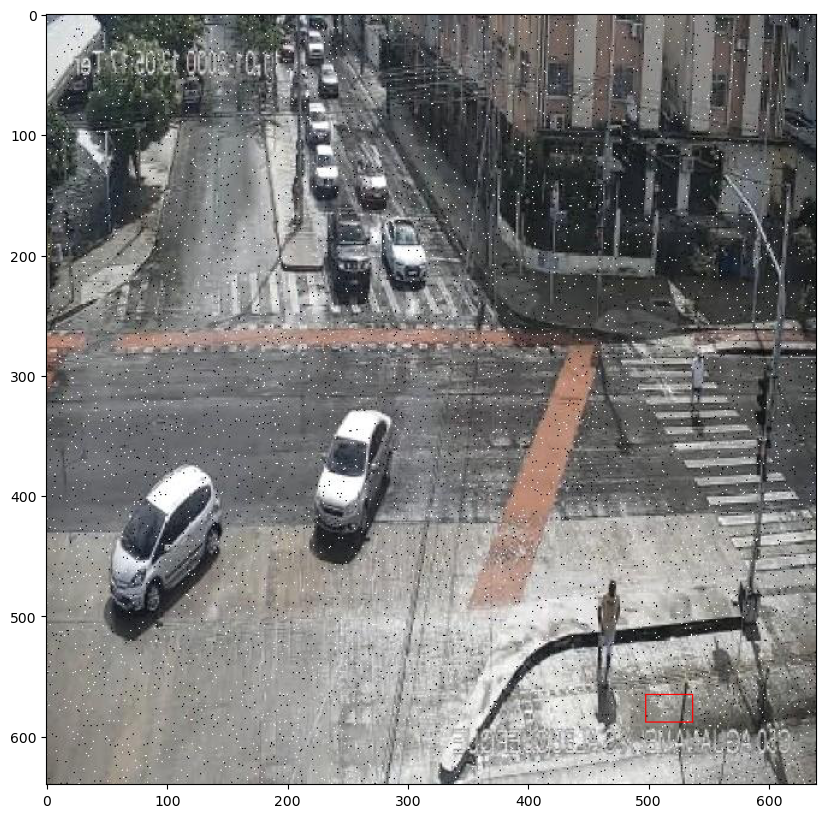

In [7]:
# Test Points
regions = cf.generate_regions(image)
regioned_image = cf.add_regions(image, [regions[0]], [255, 0, 0], 1)
# regioned_image = add_anchor_points(regioned_image, test_points, 2)
plt.figure(figsize=(10, 10))
plt.imshow(regioned_image)

In [8]:
print(f'Regions: {len(regions)}')

Regions: 12857


In [9]:
region_targets = []
for region in tqdm(regions):
    if cf.is_region_inside_image(image, region[0], region[1], region[2], region[3]):
        for object_coords in object_coordinates:
            iou = cf.find_IOU(object_coords, region)
            if iou > 0.6 or (iou < 0.3 and iou > 0):
                region_targets.append([1 if iou > 0.5 else 0, iou, region[0], region[1], region[2], region[3]])

  0%|          | 0/12857 [00:00<?, ?it/s]

100%|██████████| 12857/12857 [00:00<00:00, 18417.04it/s]


In [10]:
ious = [region[1] for region in region_targets]
max(ious)

0.8215838713928054

In [11]:
fine_regions = []
non_fine_regions = []
for i in range(0, len(region_targets)):
    if region_targets[i][0] == 1:
        fine_regions.append(region_targets[i])
    else:
        non_fine_regions.append(region_targets[i])
fine_regions = np.array(fine_regions, dtype=np.int32)
len(fine_regions), len(non_fine_regions)

(18, 13840)

In [12]:
# Taking non fine regions equal to that of fine regions
random_region_indices = np.random.choice(len(non_fine_regions), len(fine_regions))
non_fine_regions = np.array(non_fine_regions, dtype=np.int32)
non_fine_regions = non_fine_regions[random_region_indices]

In [13]:
np.append(non_fine_regions, fine_regions, axis=0).shape

(36, 6)

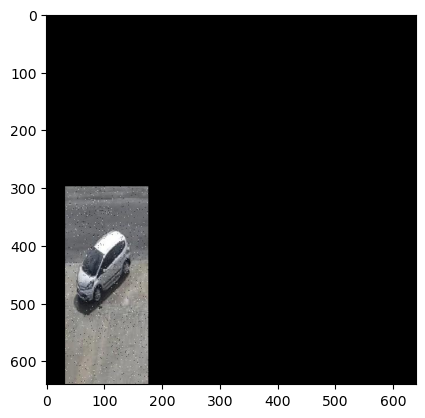

In [14]:
target = fine_regions
for i in range(17, len(target)):
    x = target[i][2]
    y = target[i][3]
    width = target[i][4]
    height=target[i][5]
    region_mask = cf.generate_masks(image, x, y, width, height)
    new_image = image.copy()
    new_image[region_mask != 1] = 0
    plt.imshow(new_image)
    break

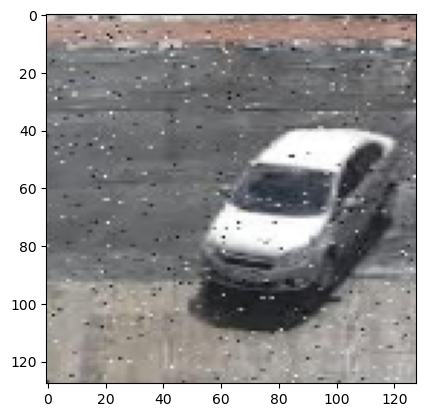

In [15]:
region = fine_regions[0]
x = region[2]
y = region[3]
width = region[4]
height = region[5]
cropped_image = image[x - width: x + width, y - height : y + height, :]
cropped_image = np.reshape(cropped_image, (width * 2, height * 2, 3))
cropped_image = cv2.resize(cropped_image, (128, 128))
plt.imshow(cropped_image)

In [16]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, folder, batch_size = 32, shuffle = True):
        self.folder = folder
        self.batch_size = batch_size
        self.images = os.listdir(f'{folder}/images')
        self.labels = os.listdir(f'{folder}/labels')
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return self.images.__len__() - 10
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            self.images, self.labels = shuffle(self.images, self.labels)

    def __getitem__(self, index):
        target_regions = []
        i = index
        while len(target_regions) == 0:
            X = []
            y = []
            image, coords = cf.load_image(self.folder, self.images, self.labels, i)
            target_regions = cf.propose_regions(image, coords, 0.6)
            for region in target_regions:
                if cf.is_region_inside_image(image, region[1], region[2], region[3], region[4]):
                    cropped_image = cf.resize_region(image, region[1], region[2], region[3], region[4], (96, 96))
                    if cropped_image.shape[0] != 0 and cropped_image.shape[1] != 0:
                        X.append(cropped_image)
                        y.append(region[0])
            i+=1
        X = np.array(X)
        y = np.array(y)
        return X, y

In [17]:
train_generator = DataGenerator(train_folder, 1)
valid_generator = DataGenerator(valid_folder, 1)

# Model Definition and Training

In [19]:
vgg16 = VGG16(include_top=False, input_shape=(96, 96, 3), weights='imagenet')

for layer in vgg16.layers:
    layer.trainable = False

last_vgg16_layer = vgg16.layers[-1]
last_vgg16_output = last_vgg16_layer.output
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

In [20]:
inception_v3 = InceptionV3(include_top= False, input_shape=(96, 96, 3), weights='imagenet')

# Making the layers non trainable
for layer in inception_v3.layers:
    layer.trainable = False

last_inception_layer = inception_v3.get_layer('mixed7')
last_inception_output = last_inception_layer.output
inception_v3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 47, 47, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 47, 47, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 47, 47, 32)   0           ['batch_normalization[

In [21]:
x = Flatten()(last_vgg16_output)
x = Dense(units=1024, activation='relu')(x)
x = Dense(units=64, activation='relu')(x)
x = Dense(units=1, activation='sigmoid')(x)
model = Model(vgg16.input, x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

Total params: 19,499,969
Trainable params: 4,785,281
Non-trainable params: 14,714,688
_________________________________________________________________


In [22]:
checkpoint = ModelCheckpoint("checkpoints/region_proposal_network.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch')
history = model.fit(train_generator, epochs= 10, steps_per_epoch=50, validation_data=valid_generator, validation_steps=20, callbacks=[checkpoint])

Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 2.1265 - accuracy: 0.6872 
Epoch 1: val_loss improved from inf to 0.43371, saving model to checkpoints\region_proposal_network.h5
50/50 [==============================] - 1489s 30s/step - loss: 2.1265 - accuracy: 0.6872 - val_loss: 0.4337 - val_accuracy: 0.8205
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.4733 - accuracy: 0.7925 
Epoch 2: val_loss improved from 0.43371 to 0.37491, saving model to checkpoints\region_proposal_network.h5
50/50 [==============================] - 1520s 31s/step - loss: 0.4733 - accuracy: 0.7925 - val_loss: 0.3749 - val_accuracy: 0.8597
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.4287 - accuracy: 0.8011 
Epoch 3: val_loss did not improve from 0.37491
50/50 [==============================] - 1448s 29s/step - loss: 0.4287 - accuracy: 0.8011 - val_loss: 0.4321 - val_accuracy: 0.8087
Epoch 4/10
50/50 [==============================] - ETA: 0s - 

In [23]:
# Saving the model
model.save('region_proposal_network.h5')

In [18]:
best_model = load_model('checkpoints/region_proposal_network.h5')

Text(0, 0.5, 'Loss')

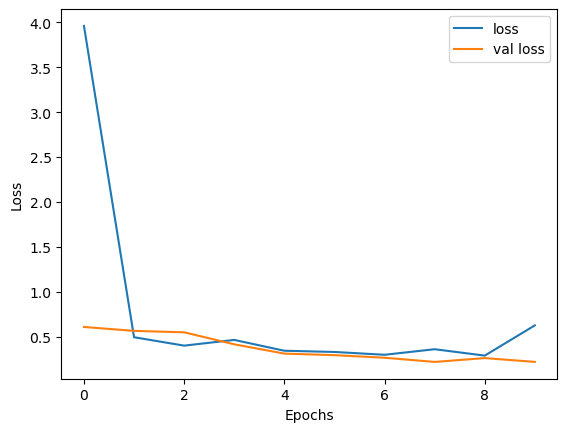

In [36]:
# Plotting the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

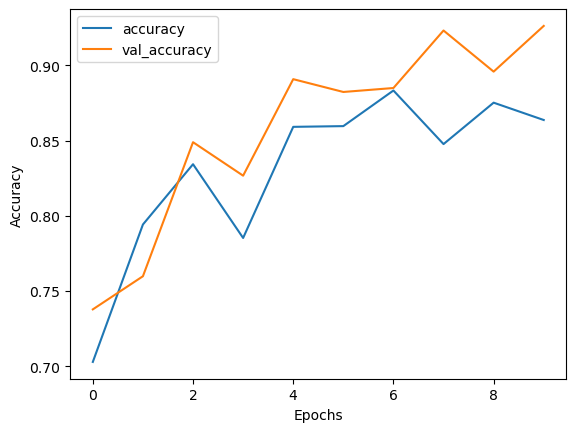

In [37]:
# Plotting the loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

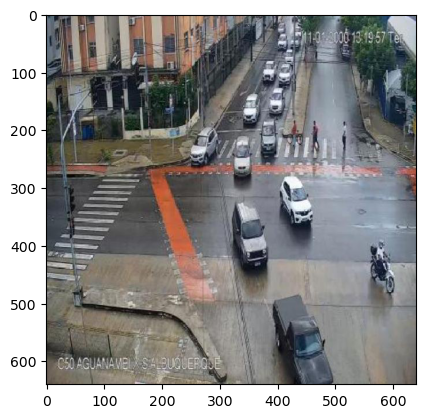

In [19]:
test_images = os.listdir(f'{test_folder}/images')
test_labels = os.listdir(f'{test_folder}/labels')
image_index = 7
test_image, test_object_coords = cf.load_image(test_folder, test_images, test_labels, image_index)
plt.imshow(test_image)

In [20]:
print(test_object_coords.__len__())
proposed_regions, proposed_region_images = cf.detect_object_regions(test_image, best_model, 0.8)

21
249/249 [==============================] - 23s 60ms/step
Proposed Regions: 8 out of 7965


[560 431  80  74]


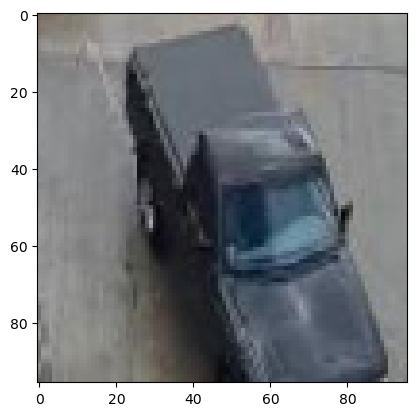

In [26]:
region_index = 4
print(proposed_regions[region_index])
plt.imshow(proposed_region_images[region_index])

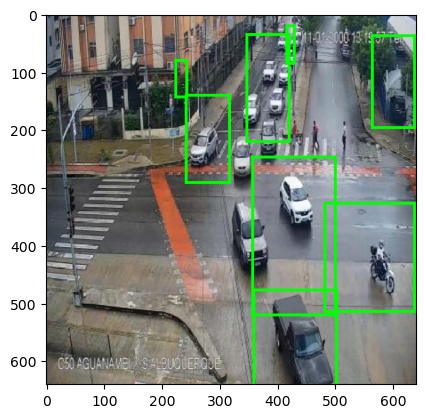

In [22]:
copied_image = test_image.copy()
for region in proposed_regions:
    copied_image = cf.draw_boundary(copied_image, colors[0], region, True, False)
plt.imshow(copied_image)